In [2]:
!gdown 1y-DIAqtPK1B9uTzI15aIfo3Yk9HdeN4W -O dataset/raw.zip
!gdown 1N4FtAXM6b6Xk1LPYMgbXxqHgPvFHTziD -O dataset/test.zip

Downloading...
From (original): https://drive.google.com/uc?id=1y-DIAqtPK1B9uTzI15aIfo3Yk9HdeN4W
From (redirected): https://drive.google.com/uc?id=1y-DIAqtPK1B9uTzI15aIfo3Yk9HdeN4W&confirm=t&uuid=a4b62cb8-3011-44a2-a172-24d08ff8165d
To: /workspace/Brain-Tumor-Classification/dataset/raw.zip
100%|██████████████████████████████████████| 61.7M/61.7M [00:01<00:00, 40.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1N4FtAXM6b6Xk1LPYMgbXxqHgPvFHTziD
From (redirected): https://drive.google.com/uc?id=1N4FtAXM6b6Xk1LPYMgbXxqHgPvFHTziD&confirm=t&uuid=85ef87bc-1877-4828-89e0-d739528f785c
To: /workspace/Brain-Tumor-Classification/dataset/test.zip
100%|████████████████████████████████████████| 156M/156M [00:06<00:00, 22.9MB/s]


In [1]:
import matplotlib.pyplot as plt
import os
import zipfile
import shutil
from PIL import Image
import SimpleITK as sitk
import numpy as np
import pandas as pd
import dask.bag as db
import diagnostics
import dask.diagnostics as dd
import cv2

In [2]:
cwd = os.getcwd()
cwd

'/workspace/Brain-Tumor-Classification'

In [13]:
folder_paths = [
    os.path.join(cwd, 'dataset', 'raw', 'Training', 'glioma'),
    os.path.join(cwd, 'dataset', 'raw', 'Training', 'meningioma'),
    os.path.join(cwd, 'dataset', 'raw', 'Training', 'pituitary'),
    os.path.join(cwd, 'dataset', 'raw', 'Training', 'notumor')
]

In [4]:
def unzip(zip_path, extract_to=None):
    cwd = os.getcwd()
    if extract_to is None:
        extract_to = zip_path
    extract_to = "dataset/" + extract_to
    extract_path = os.path.join(cwd, extract_to)
    
    # Remove existing directory if it exists
    if os.path.exists(extract_path):
        shutil.rmtree(extract_path)
        print(f"Removed existing directory: {extract_path}")
    os.makedirs(extract_path, exist_ok=True)
    print(f"Created directory: {extract_path}")

    # Define allowed image extensions
    allowed_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp')

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Iterate through each file in the zip
        for file_info in zip_ref.infolist():
            # Check if the file is an image by its extension
            if file_info.filename.lower().endswith(allowed_extensions):
                zip_ref.extract(file_info, extract_path)

    # Clean up the __MACOSX folder if it exists
    macosx_path = os.path.join(extract_path, '__MACOSX')
    if os.path.exists(macosx_path): 
        shutil.rmtree(macosx_path)

    # Remove all .DS_Store files
    for root, dirs, files in os.walk(extract_path):
        for file in files:
            if file == '.DS_Store':
                os.remove(os.path.join(root, file))

    print(f"Extraction completed with only image files in {extract_path}")

In [5]:
def unzip(zip_path, extract_to):
    cwd = os.getcwd()
    if extract_to is None:
        extract_to = zip_path
    extract_to = "dataset/" + extract_to
    extract_path = os.path.join(cwd, extract_to)
    
    if os.path.exists(extract_path):
        shutil.rmtree(extract_path)
        print(f"Removed existing directory: {extract_path}")
    os.makedirs(extract_path, exist_ok=True)
    print(f"Created directory: {extract_path}")

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        if os.path.exists(extract_path+'/__MACOSX'): 
            shutil.rmtree(extract_path+'/__MACOSX')
        for root, dirs, files in os.walk(extract_path):
            for file in files:
                file_path = os.path.join(root, file)
                if file == '.DS_Store' and os.path.isfile(file_path):
                    os.remove(file_path)
        print(f"Extracted all files to {extract_path}")

In [25]:
zip_file = cwd + '/dataset/raw.zip'
unzip(zip_file, 'test')

Created directory: /workspace/Brain-Tumor-Classification/dataset/test
Extracted all files to /workspace/Brain-Tumor-Classification/dataset/test


In [7]:
test_zip_file = cwd + '/dataset/test.zip'
unzip(test_zip_file, 'raw')

Created directory: /workspace/Brain-Tumor-Classification/dataset/raw
Extracted all files to /workspace/Brain-Tumor-Classification/dataset/raw


In [11]:
def display_images(folder_path, num_images=4):
    fig, axes = plt.subplots(len(folder_paths), num_images, figsize=(16,16))

    for i, folder_path in enumerate(folder_paths):
        files = os.listdir(folder_path)
        files = files[:num_images]

        for j, file in enumerate(files):
            file_path = os.path.join(folder_path, file)
            img = Image.open(file_path)

            img_width, img_height = img.size

            axes[i,j].imshow(img)
            axes[i,j].axis('off')
            axes[i,j].set_title(f'{folder_paths[i][125:]}, Image {j+1}, ({img_width}x{img_height})')

    plt.tight_layout()
    plt.show()


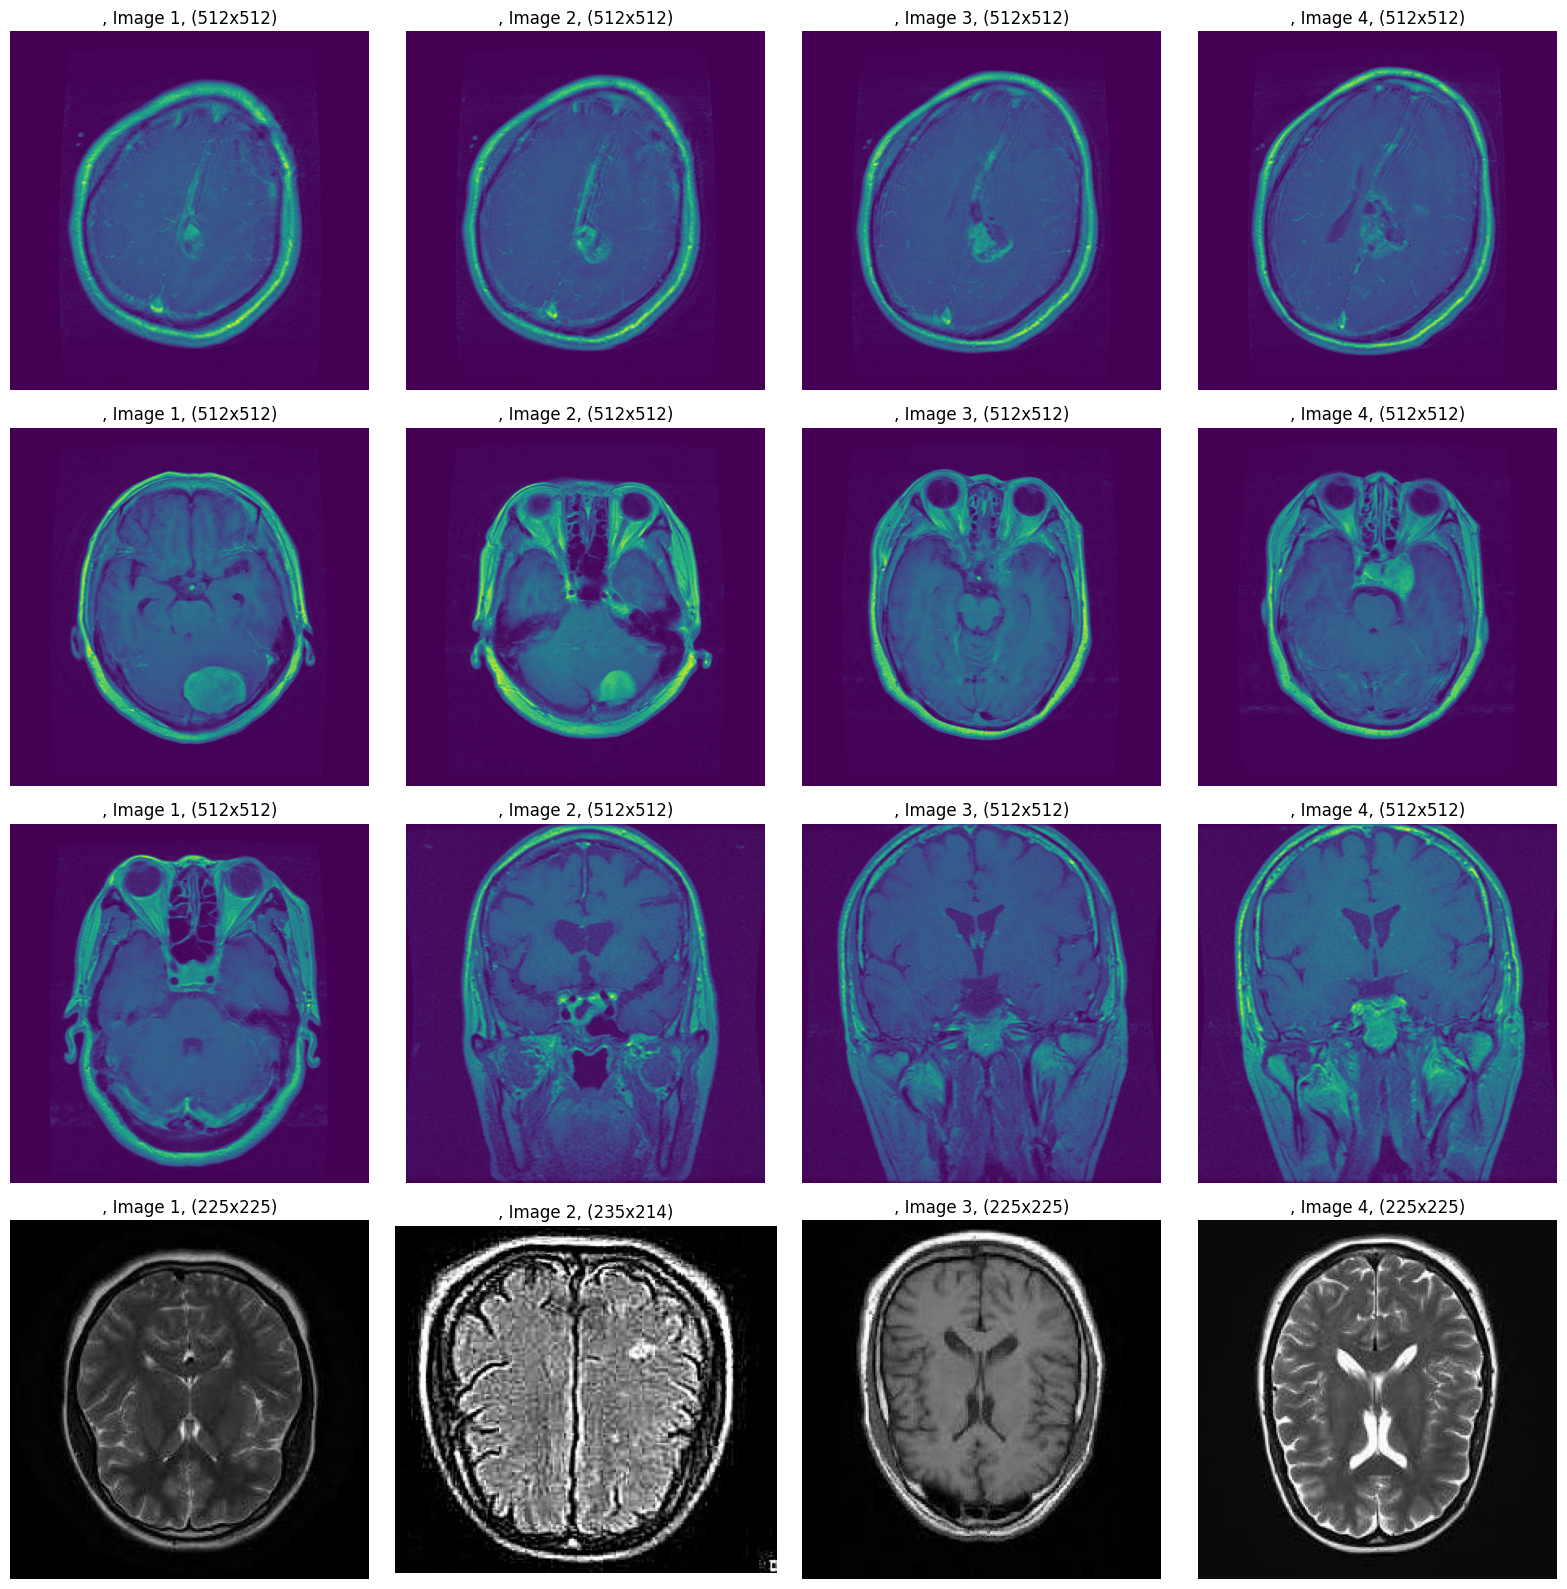

In [14]:
display_images(folder_paths)

Text(0, 0.5, '# Images')

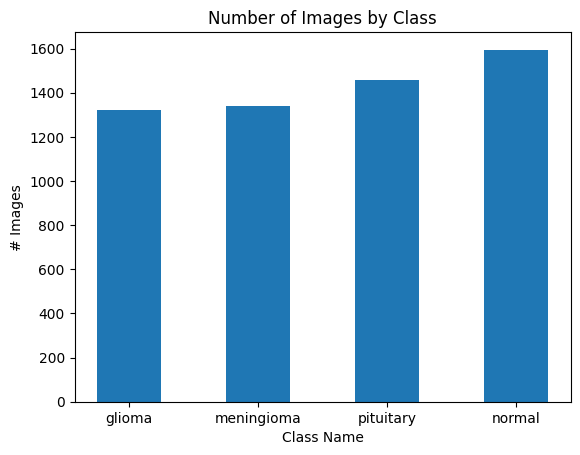

In [15]:
number_classes = {
    'glioma': len(os.listdir(folder_paths[0])),
    'meningioma': len(os.listdir(folder_paths[1])),
    'pituitary': len(os.listdir(folder_paths[2])),
    'normal': len(os.listdir(folder_paths[3]))
}

plt.bar(number_classes.keys(), number_classes.values(), width = 0.5)
plt.title('Number of Images by Class')
plt.xlabel('Class Name')
plt.ylabel('# Images')

In [16]:
def get_dims(file_path):
    img = Image.open(file_path).convert('L')
    arr = np.array(img)
    h,w = arr.shape

    return h,w

[########################################] | 100% Completed | 1.45 ss


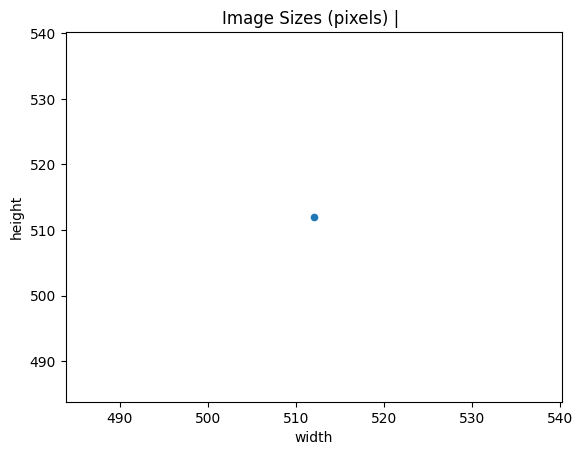

[########################################] | 100% Completed | 1.73 ss


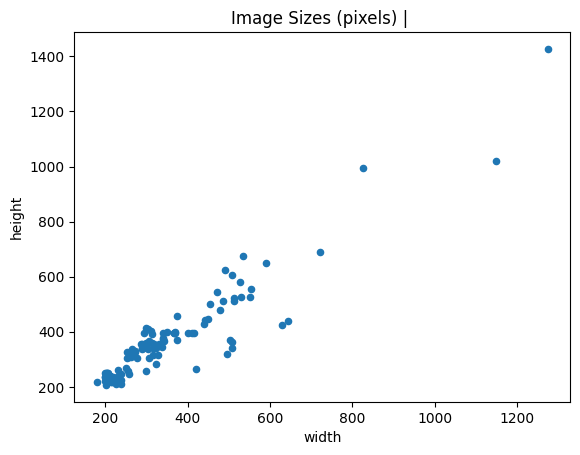

[########################################] | 100% Completed | 1.56 ss


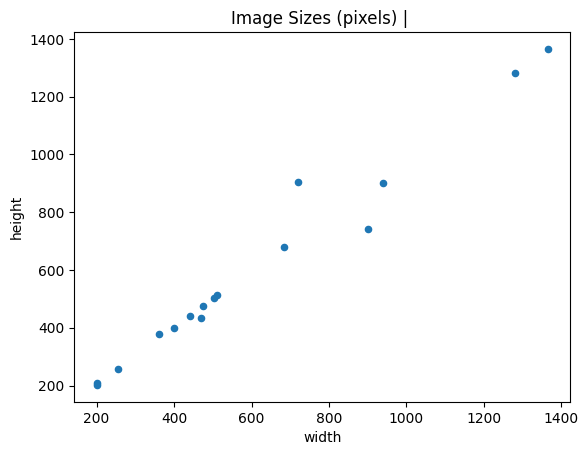

[########################################] | 100% Completed | 1.76 ss


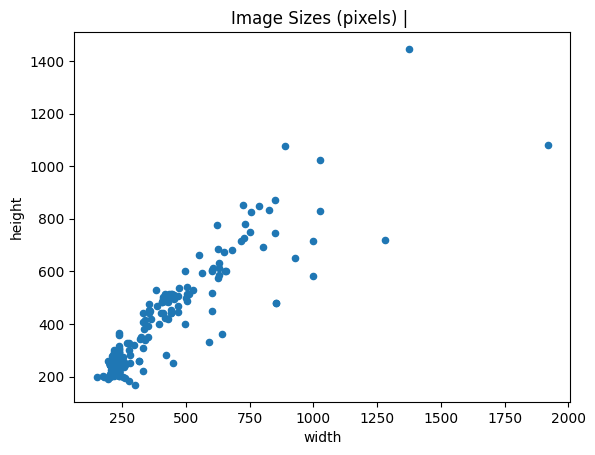

In [17]:
def get_dims(file_path):
    """Function to get the dimensions of an image."""
    img = Image.open(file_path).convert('L')  # Convert to grayscale
    arr = np.array(img)
    h, w = arr.shape
    return h, w

for path in folder_paths:
    file_path = path
    # Get only files (exclude directories)
    file_list = [os.path.join(file_path, f) for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))]
    
    # Process the files using dask bag
    dims = db.from_sequence(file_list).map(get_dims)
    
    # Compute dimensions with progress bar
    with dd.ProgressBar():
        dims = dims.compute()
        
    # Create a dataframe and group by height and width
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0: 'count'})
    
    # Plot image sizes
    sizes.plot.scatter(x='width', y='height')
    plt.title(f'Image Sizes (pixels) | {path[125:]}')
    plt.show()

In [18]:
def calculate_image_mean(image_path):
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)

    return np.mean(img_array)

def calculate_folders_means(folder_paths):
    folder_means = {}

    for folder_path in folder_paths:
        means = []
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if os.path.isfile(file_path):
                mean_intensity = calculate_image_mean(file_path)
                means.append(mean_intensity)
        folder_means[os.path.basename(folder_path)] = means

    return folder_means

def plot_histogram(folder_means):
    plt.figure(figsize=(10,6))

    for folder, means in folder_means.items():
        plt.hist(means, bins=30, alpha=0.5, label=folder)

    plt.xlabel('Mean Intensity')
    plt.ylabel('Frequency')
    plt.title('Histogram of Mean Intensities per Folder')
    plt.legend()
    plt.show()

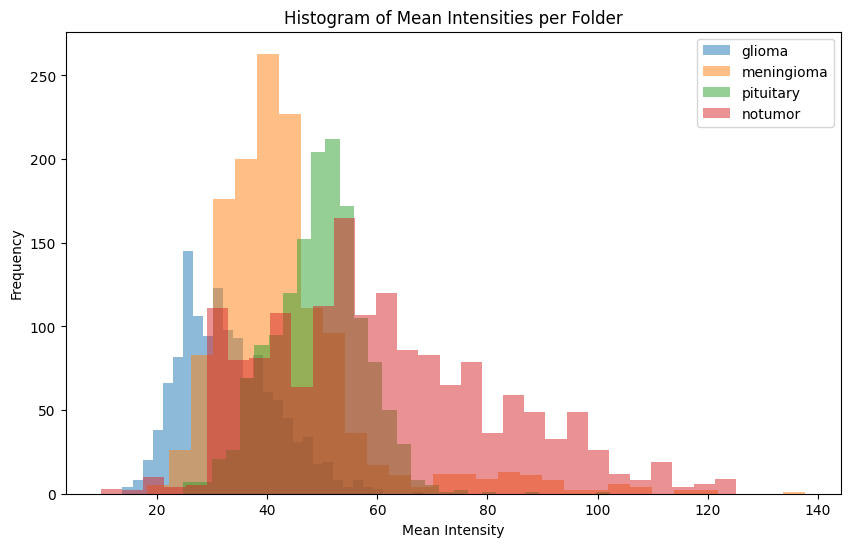

In [19]:
folder_means = calculate_folders_means(folder_paths)
plot_histogram(folder_means)

In [20]:
def calculate_image_statistics(image_path):
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)
    mean = np.mean(img_array)
    std = np.std(img_array)
    min_val = np.min(img_array)
    max_val = np.max(img_array)
    median = np.median(img_array)
    skewness = np.mean((img_array - mean)**3) / std**3
    kurtosis = np.mean((img_array - mean)**4) / std**4-3
    return {
        'mean': mean,
        'std': std,
        'min': min_val,
        'max': max_val,
        'median': median,
        'skewness': skewness,
        'kurtosis': kurtosis
    }

def calculate_folder_statistics(folder_path):
    all_stats = {}

    for folder_path in folder_paths:
        stats = []
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if os.path.isfile(file_path):
                stat = calculate_image_statistics(file_path)
                stats.append(stat)
            all_stats[os.path.basename(folder_path)] = stats

    return all_stats

def plot_pixel_histogram(image_path):
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)
    plt.hist(img_array.flatten(), bins=50, color='blue', alpha=0.7)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title('Histogram of Pixel Intensities')
    plt.show()

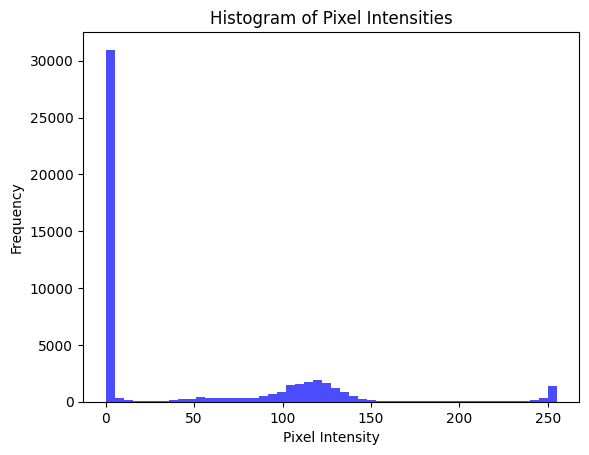

In [22]:
image_path = cwd+'/dataset/raw/Training/notumor/Tr-no_0010.jpg'
plot_pixel_histogram(image_path)

In [23]:
statistics = calculate_folder_statistics(folder_paths)
for folder, stats in statistics.items():
    means = [s['mean'] for s in stats]
    print(f'{folder} - Mean intensity: {np.mean(means):.2f} ± {np.std(means):.2f}')

glioma - Mean intensity: 32.71 ± 8.56
meningioma - Mean intensity: 43.48 ± 14.30
pituitary - Mean intensity: 49.27 ± 8.22
notumor - Mean intensity: 60.72 ± 21.24


In [24]:
def plot_color_range(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert the image from BGR (OpenCV default) to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Split the image into its respective Red, Green, and Blue channels
    r_channel, g_channel, b_channel = cv2.split(image_rgb)
    
    # Create a figure and axis
    plt.figure(figsize=(15, 5))
    
    # Plot histogram for Red channel
    plt.subplot(1, 3, 1)
    plt.hist(r_channel.ravel(), bins=256, color='red', alpha=0.5)
    plt.title('Red Channel')
    plt.xlim([0, 256])
    
    # Plot histogram for Green channel
    plt.subplot(1, 3, 2)
    plt.hist(g_channel.ravel(), bins=256, color='green', alpha=0.5)
    plt.title('Green Channel')
    plt.xlim([0, 256])
    
    # Plot histogram for Blue channel
    plt.subplot(1, 3, 3)
    plt.hist(b_channel.ravel(), bins=256, color='blue', alpha=0.5)
    plt.title('Blue Channel')
    plt.xlim([0, 256])
    
    # Show the plots
    plt.tight_layout()
    plt.show()

# Example usage
plot_color_range(cwd+'/dataset/raw/glioma_tumor/G_1.jpg')

[ WARN:0@499.253] global loadsave.cpp:241 findDecoder imread_('/workspace/Brain-Tumor-Classification/dataset/raw/glioma_tumor/G_1.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
cwd